## Algorithm Description: Wavelet Spike Rejection

### Motivation & Goal of Algorithm
###### What problem does the data have that requires this algorithm to fix it?

After the noise channel regression step, we notice that the range of values that our data take on is extremely wide. This is certainly due to some sort of noise, since we expect these data to have values on the order of $10^2 \mu V$, while we are observing values on the order of $10^3 \mu V$. We notice that these periods of high voltage can be localized to short spikes, which are likely due to noise. We attempt to better visualize this problem below.

#### Loading the data...

In [1]:
%matplotlib inline
import cPickle as pkl
base = '../../data/'
path = 'bids_raw/sub-0001/ses-01/eeg/'
file_name = 'sub-0001_ses-01.pkl'
full_path = base + path + file_name
with open(full_path, 'rb') as f:
    D = pkl.load(f)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from panda.methods import viz as viz
from panda import config
p_global = config.params['p_global']
eog_chans = np.array(p_global['eog_chans']) - 1
eeg_chans = np.setdiff1d(np.arange(128), eog_chans)
p_global.update({'eog_chans': eog_chans,
                'eeg_chans': eeg_chans})

p_global['plotting']['notebook'] = True
from panda.methods.misc import setup
from panda.methods.denoise import highpass
from panda.methods.denoise import bandstop
from panda.methods.denoise import eog_regress
(D, p_local) = setup(D, {}, p_global)
(D, p_local) = highpass(D, p_local, p_global)
(D, p_local) = eog_regress(D, p_local, p_global)

#### Visualizing the data...

##### Heatmaps
Here, we notice in the heatmaps plotted in the symmetric logarithm scale (2nd and 3rd heatmaps) that a vast majority of the values in our data matrix are relatively low. This can also be seen in the raw heatmap since it is appears to be almost entirely white, meaning most values are very close to zero relative to the scale chosen. There are only a few sparsely supported points that take on the highest values of the range.

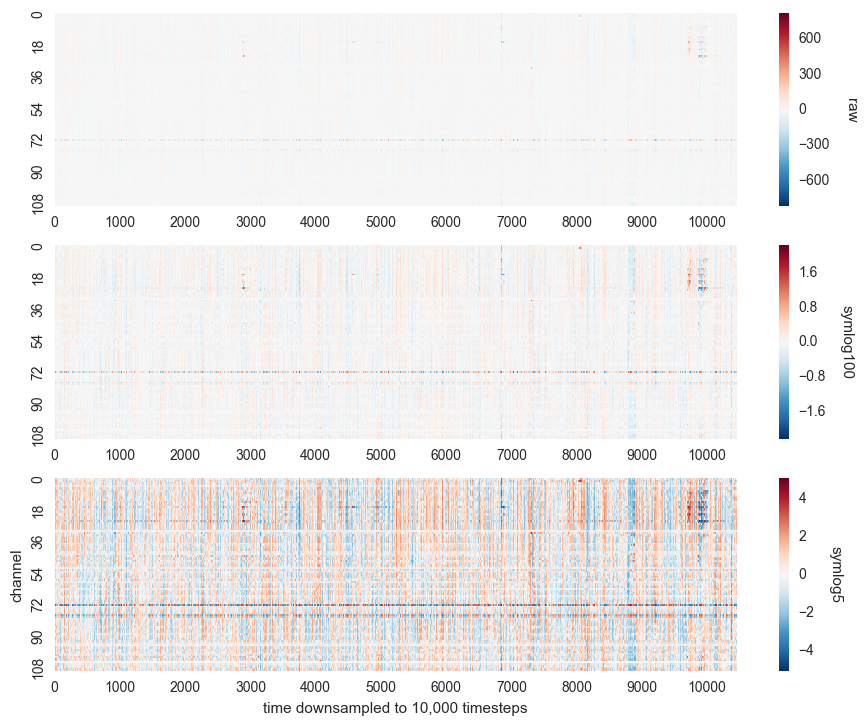

In [2]:
viz.heatmap(D, p_local, p_global)

##### Sparklines
Here, we visualize sparklines of a few channels which demonstrate the problem well. We see in channel 16 that there is one huge spike that goes between $-1000 \mu V$ and $1000 \mu V$ in a very short period of time. We see similar spikes in the other channels (24 and 38).

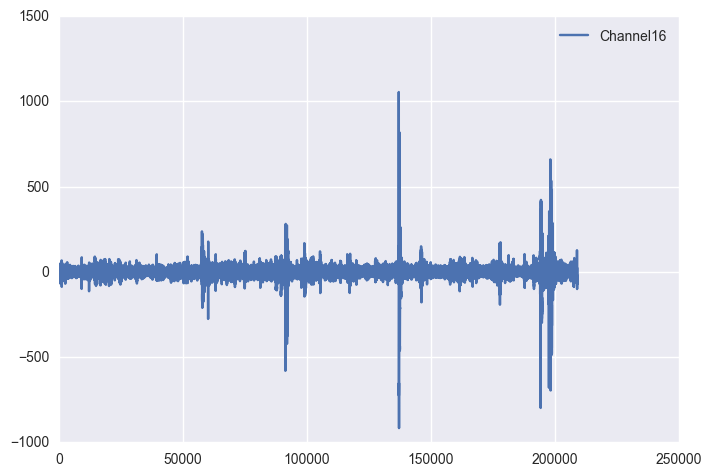

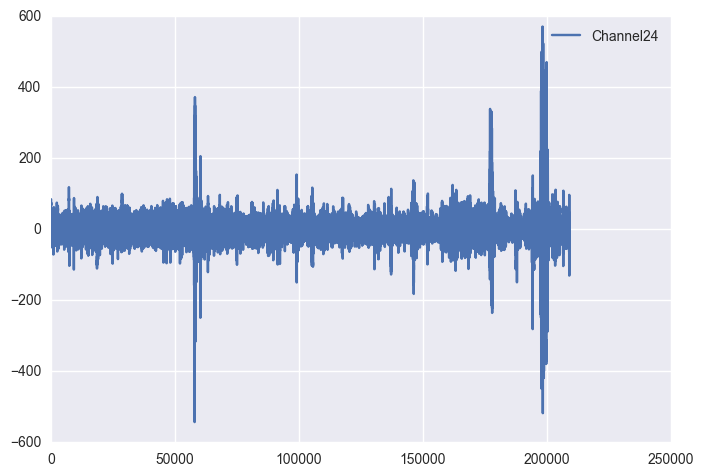

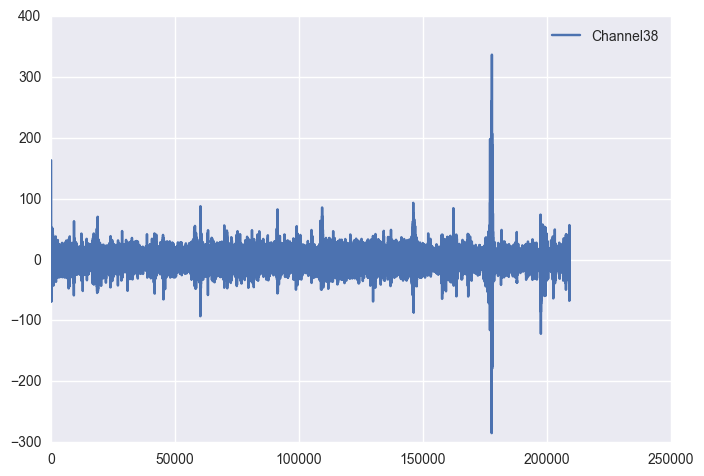

In [3]:
sparkchans = [16, 24, 38]
for i in sparkchans:
    plt.plot(D[i, :], label = 'Channel' + str(i))
    plt.legend()
    plt.show()

As we can see, there are short time segments where the signal changes rapidly, which is likely due to artifacts involving muscle or eye movements. 

To remove these, we use a wavelet based coefficient rejection technique.

### Setting
Suppose we have multidimensional time series data with $C$ channels (dimensions) and $T$ timesteps. Let $M \in \mathbb{R}^{C \times T}$ be the matrix of these observations.

Suppose there are spikes that occur throughout the matrix, which manifest themselves in short, high energy spikes in single channels. We can model each dimension of the time series as a function, e.g. row $i$ of $M$ is described by a function $f_i$ such that the observations $M[i, :]$ correspond to the function $f_i$ sampled discretely at the $T$ timepoints representing the columns of $M$ (e.g. $M[i, :] = [f_i(1),\, f_i(2),\, \ldots,\, f_i(T)]$).

Now we take a $j$ level discrete wavelet transform of each function $f_i$ to recieve the coefficient set $(\{ \langle \phi_{m, k}, f \rangle_{L_2} \}_{k = 0}^{2^m - 1}, \{ \langle \psi_{m + 1, k}, f \rangle_{L_2} \}_{k = 0}^{2^{m + 1} - 1}, \ldots, \{ \langle \psi_{m + j, k}, f \rangle_{L_2} \}_{k = 0}^{2^{m + j} - 1})_i$. The scale coefficients ($\psi$'s) tend to take on large values around time scales of high discontinuity, and further the multiscale property of wavelets allow us to localize this point of high discontinuity. We will do so by looking at the magnitudes of the detail coefficients and rejecting those which are extreme outliers in magnitude ($\approx \pm 16 \sigma$ from $\mu$).

#### Algorithm Pseudocode
On input $(M, t, j, `wave`)$:
Where
* $M \in \mathbb{R}^{C \times T}$ is the matrix of EEG data.
* $t$ is the cutoff threshold for the wavelet coefficients
* $j$ is the number of levels of detail coefficients to take
* `wave` is the type of wavelet to use

Begin Procedure: 
1. Compute the discrete wavelet transform $(\{ \langle \phi_{m, k}, f \rangle_{i} \}_{k = 0}^{2^m - 1}, \{ \langle \psi_{m + 1, k}, f \rangle_{i} \}_{k = 0}^{2^{m + 1} - 1}, \ldots, \{ \langle \psi_{m + j, k}, f \rangle_{i} \}_{k = 0}^{2^{m + j} - 1}) = \mathcal{W}(M[i, :], `wave`)$ for each $i$
2. Compute the mean of the wavelet coefficients $\mu = \frac{\sum_{i = 1}^{C}\sum_{j = m}^{j + m}\sum_{k=0}^{2^{m + j} - 1} \langle \psi_{j + m, k} \rangle_i}{\sum_{i = 1}^{C}\sum_{j = m}^{j + m}\sum_{k=0}^{2^{m + j} - 1}}$
3. Compute the variance of the wavelet coefficients $\sigma^2 = \frac{(\sum_{i = 1}^{C}\sum_{j = m}^{j + m}\sum_{k=0}^{2^{m + j} - 1} \langle \psi_{j + m, k} \rangle_i - \mu)^2}{\sum_{i = 1}^{C}\sum_{j = m}^{j + m}\sum_{k=0}^{2^{m + j} - 1}}$
4. Set to $0$ all wavelet coefficients $\langle \psi_{j + m, k} \rangle_i$ which have absolute value larger than $t\sigma$.
5. Reconstruct each row of the matrix $M$ by taking the inverse discrete wavelet transform $M'[i, :] = \mathcal{W}^{-1}((\{ \langle \phi_{m, k}, f \rangle_{i} \}_{k = 0}^{2^m - 1}, \{ \langle \psi_{m + 1, k}, f \rangle_{i} \}_{k = 0}^{2^{m + 1} - 1}, \ldots, \{ \langle \psi_{m + j, k}, f \rangle_{i} \}_{k = 0}^{2^{m + j} - 1}), `wave`)$ for each $i$
6. Return $M'$.

End Procedure

#### Real Code
The code for this function is located in our [`panda.denoise`](https://github.com/rmarren1/panda/blob/master/panda/methods/denoise.py) package in the `wave_rejection` function.

### Simulations

#### Generating Sample Data
We generate two types of sample data: data for which we expect the algorithm to perform well, and data for which we expect the algorithm to perform poorly.
1. (Good Case) We model our data $M$ as $M = S + N$ where $S$ is a generally low energy, low frequency signal, while $N$ is a noise matrix with high energy, high frequency, and temporally short noise impulses.
2. (Bad Case) We model our data $M$ as $M = S + N$ where $S$ is a generally low energy, low frequency signal, but $N$ is instead low energy gaussian noise.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def good_data(D, p_global):
    eeg_chans = p_global['eeg_chans']
    eog_chans = p_global['eog_chans']
    T = 4096
    X = np.linspace(0, 10, T)
    params = [(np.random.uniform(5, 10) * np.pi, np.random.uniform() * 5) for i in range(D)]
    S = np.vstack([p[1] * np.sin(p[0] * X) for p in params])
    params = [(np.random.uniform(40, 50) * np.pi, np.random.uniform() * 30) for i in range(D)]
    N = np.vstack([p[1] * np.sin(p[0] * X) for p in params])
    mask = []
    for i in range(D):
        zeros = np.zeros(5000)
        random_left = np.random.randint(0, T - 500)
        random_middle = np.random.randint(20, 40)
        random_right = T - random_middle - random_left
        m = np.hstack([np.ones(random_left), np.zeros(random_middle), np.ones(random_right)])
        mask.append(m)
    mask = np.array(mask).astype(bool)
    N[mask] = 0
    return S + N, S

def bad_data(D, p_global):
    eeg_chans = p_global['eeg_chans']
    eog_chans = p_global['eog_chans']
    T = 4096
    X = np.linspace(0, 10, T)
    params = [(np.random.uniform(4, 6) * np.pi, np.random.uniform() * 10) for i in range(D)]
    S = np.vstack([p[1] * np.sin(p[0] * X) for p in params])
    params = [(np.random.uniform(10, 12) * np.pi, np.random.uniform() * 10) for i in range(D)]
    S_p = np.vstack([p[1] * np.sin(p[0] * X) for p in params])
    S = S + S_p
    params = [(np.random.uniform(20, 24) * np.pi, np.random.uniform() * 15) for i in range(D)]
    S_p = np.vstack([p[1] * np.sin(p[0] * X) for p in params])
    S = S + S_p
    N = np.random.normal(0, 10, [D, T])
    return S + N, S

def sparklines(r, d, den, title):
    sns.set_style('whitegrid')
    C = d.shape[0]
    T = d.shape[1]
    fig = plt.figure(figsize=(12,1.5 * C))
    first = plt.subplot(C, 1, 1)
    plt.plot(d[0, :], 'b-', label = 'noisy')
    plt.plot(den[0, :], 'r-', label = 'denoised')
    plt.plot(r[0, :], 'g--', label = 'original')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.setp(first.get_xticklabels(), visible=False)
    plt.setp(first.get_yticklabels(), visible=False)
    plt.ylabel('1')
    for i in range(1, C):
        axes = plt.subplot(C, 1, i + 1, sharex = first)
        plt.plot(d[i, :], 'b-')
        plt.plot(den[i, :], 'r-')
        plt.plot(r[i, :], 'g--')
        plt.setp(axes.get_xticklabels(), visible=False)
        plt.setp(axes.get_yticklabels(), visible=False)
        plt.ylabel(str(i + 1))
    plt.tight_layout()
    plt.xlim([0,T])
    plt.subplots_adjust(top = 1, bottom = 0)
    return plt.gcf()

def coef_pyramid_plot(coefs, title = 'Wavelet Coefficients', first=0, scale='not_uniform', ax=None, color = 'black'):
    n_levels = len(coefs)
    if ax is None:
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, axisbg='lightgrey')
    else:
        fig = ax.figure

    if scale == 'uniform':
        biggest = [np.max(np.abs(np.hstack(coefs)))] * n_levels
    else:
        # multiply by 2 so the highest bars only take up .5
        biggest = [np.max(np.abs(i))*2 for i in coefs]

    for i in range(first,n_levels):
        x = np.linspace(0, 1, len(coefs[i]))
        ymin = n_levels - i - 1 + first
        if biggest[i] != 0:
            yheight = coefs[i]/biggest[i]
        else:
            yheight = 0
        ymax = yheight + ymin
        ax.vlines(x, ymin, ymax, linewidth=.5, color = color)

    ax.set_xlim(0,1)
    ax.set_ylim(first - 1, n_levels)
    ax.yaxis.set_ticks(np.arange(n_levels-1,first-1,-1))
    ax.yaxis.set_ticklabels(np.arange(first,n_levels))
    ax.tick_params(top=False, right=False, direction='out', pad=6)
    ax.set_ylabel("Levels", fontsize=14)
    ax.grid(True, alpha=.85, color='white', axis='y', linestyle='-')
    ax.set_title('Wavelet Detail Coefficients', fontsize=16,
            position=(.5,1.05))
    fig.subplots_adjust(top=.89)
    plt.title(title)

    return fig

##### Qualatative Assessment (good)
Here we sample many signals and see whether or not visually our denoised signal is close to our latent signal than the noisy signal is. This is shown affirmatively below.

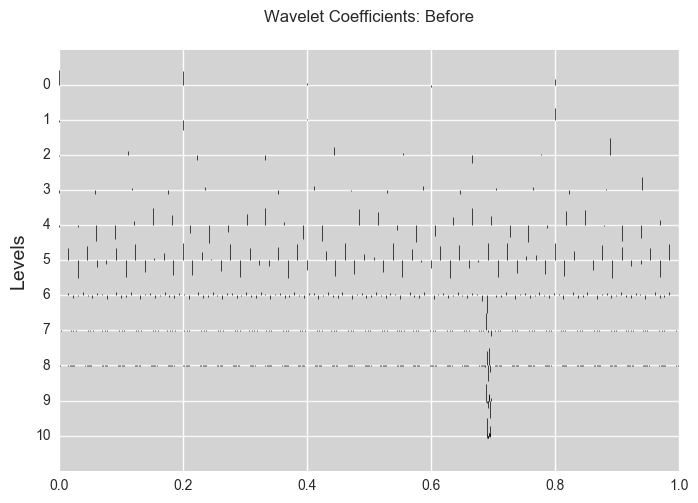

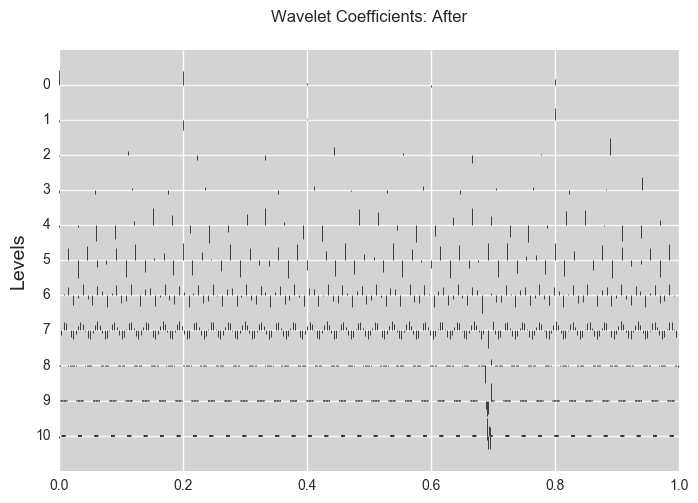

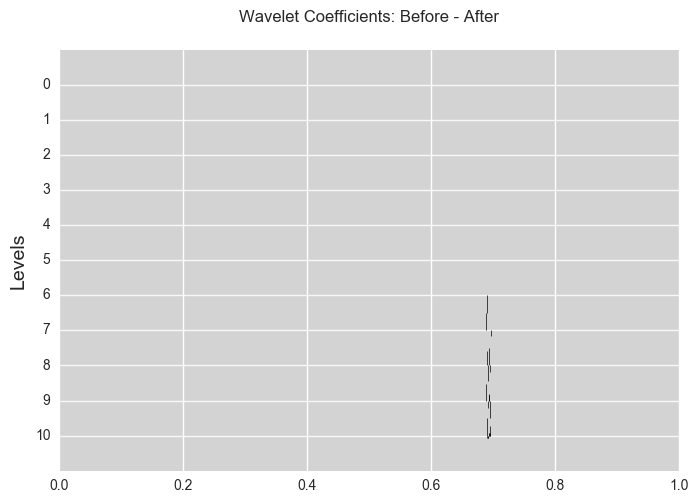

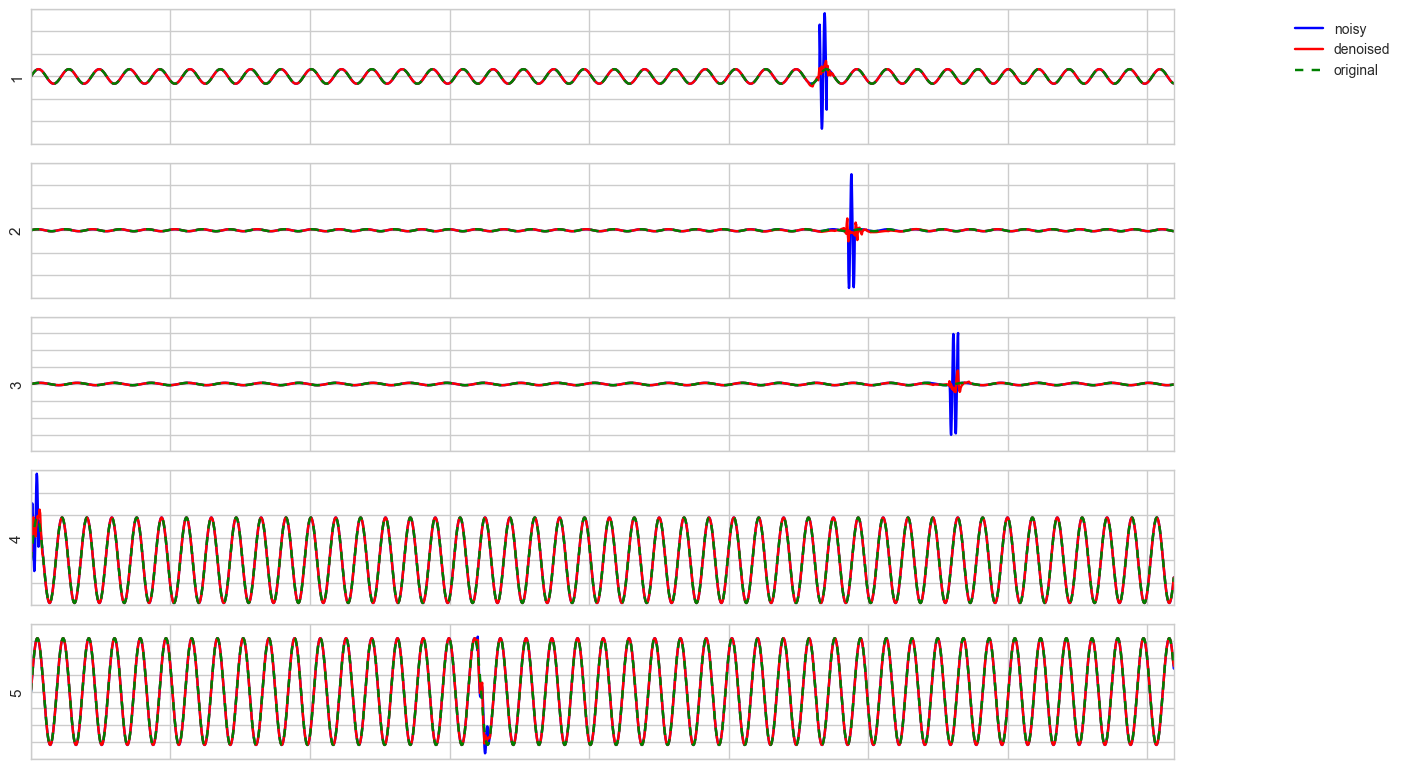

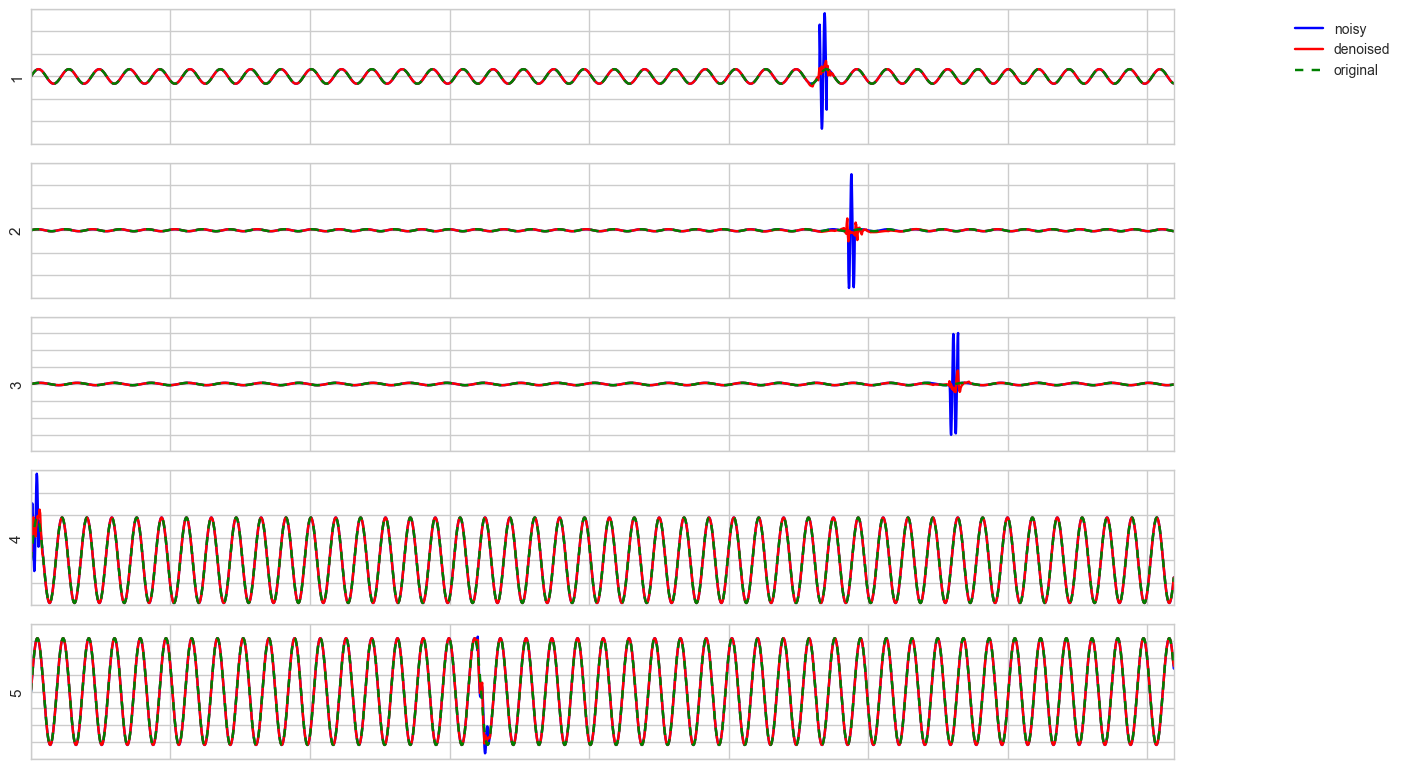

In [5]:
from panda.methods.denoise import wave_rejection
import pywt
# don't reconstruct in function
p_global['wave_rej']['rec'] = False
p_global['wave_rej']['thresh'] = 4
Y, S = good_data(5, p_global)
before = pywt.wavedec(Y[0, :], 'db2', level = 10)
coef_pyramid_plot(before, title = 'Wavelet Coefficients: Before')
plt.show()
(S_hat, p_local) = wave_rejection(Y, p_local, p_global)
coef_pyramid_plot(S_hat[0], title = 'Wavelet Coefficients: After')
plt.show()
res = [before[i] - S_hat[0][i] for i in range(len(before))]
coef_pyramid_plot(res, title = 'Wavelet Coefficients: Before - After')
plt.show()
sigs = []
for coef in S_hat:
    sigs.append(pywt.waverec(coef, 'db2'))
sparklines(S, Y, np.vstack(sigs), '')
#plt.show()

##### Quantitative Assessment (good)
Here, we repeat the above process many times, and take the $L_2$ norm of two signals as a measure of their distance. We want to see that the denoised signal is closer to the latent signal than the noisy signal is. This is answered affirmatively as shown below:

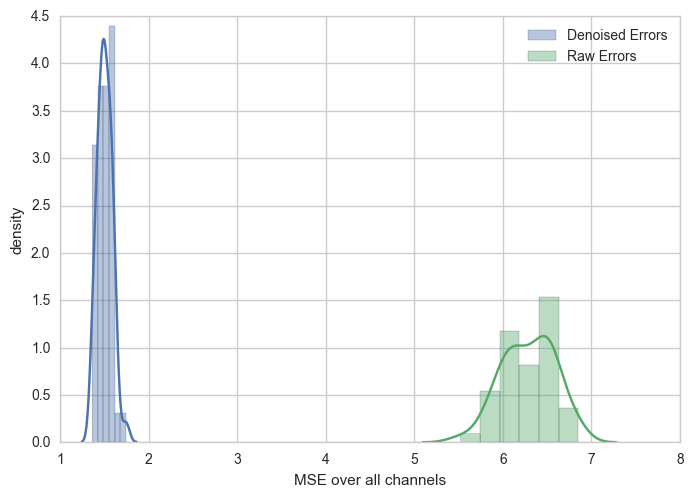

In [6]:
den_errs = []
raw_errs = []
p_global['wave_rej']['rec'] = True
for i in range(50):
    bigd = 111
    Y, S = good_data(bigd, p_global)
    (S_hat, p_local) = wave_rejection(Y, {}, p_global)
    den_errs.append(np.linalg.norm(S_hat - S) / (bigd))
    raw_errs.append(np.linalg.norm(Y - S) / (bigd))
sns.distplot(den_errs, label='Denoised Errors')
sns.distplot(raw_errs, label='Raw Errors')
plt.xlabel('MSE over all channels')
plt.ylabel('density')
plt.legend()
plt.show()

##### Qualatative Assessment (bad)
Here we sample many signals and see whether or not visually our denoised signal is close to our latent signal than the noisy signal is. We expect this case to perform poorly, and indeed it does.

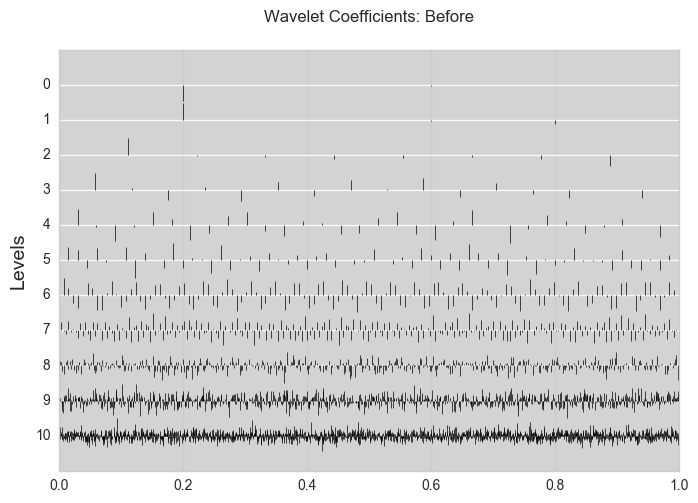

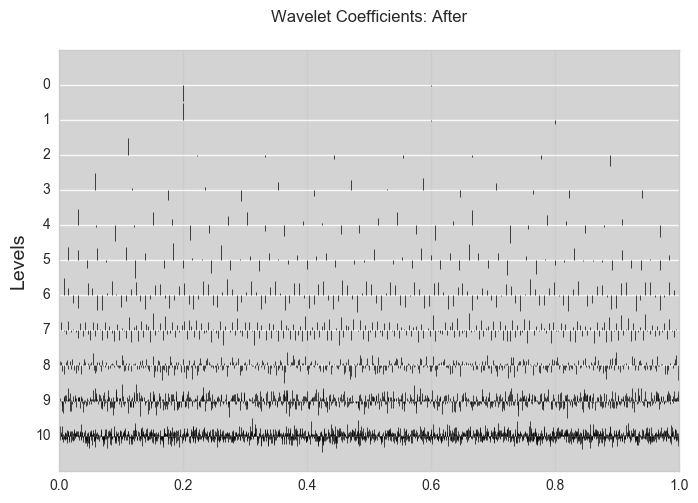

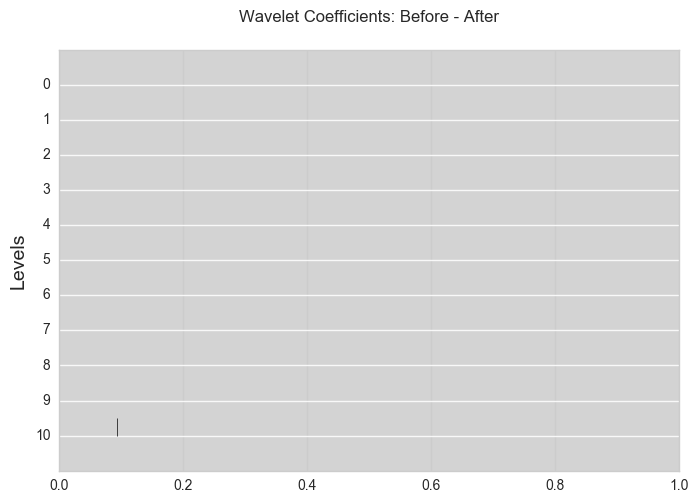

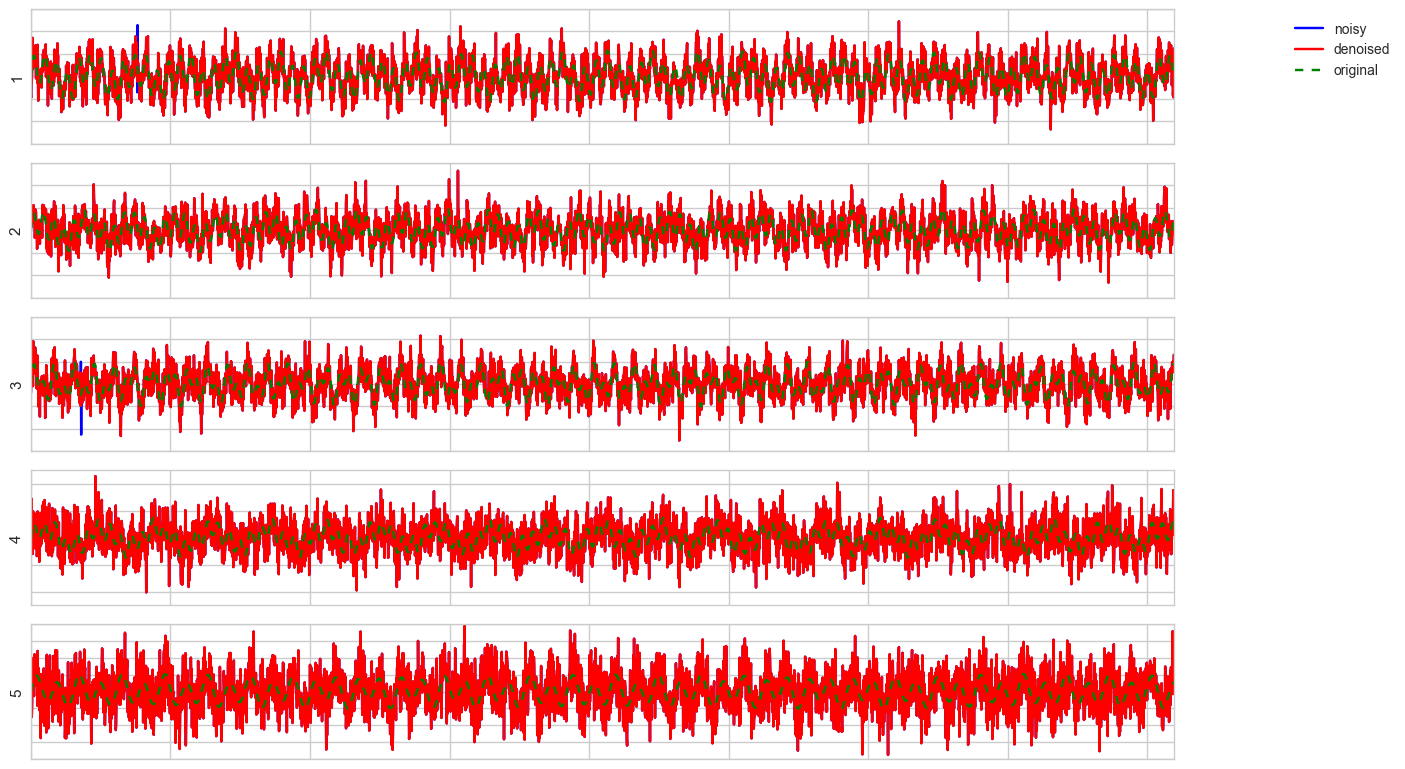

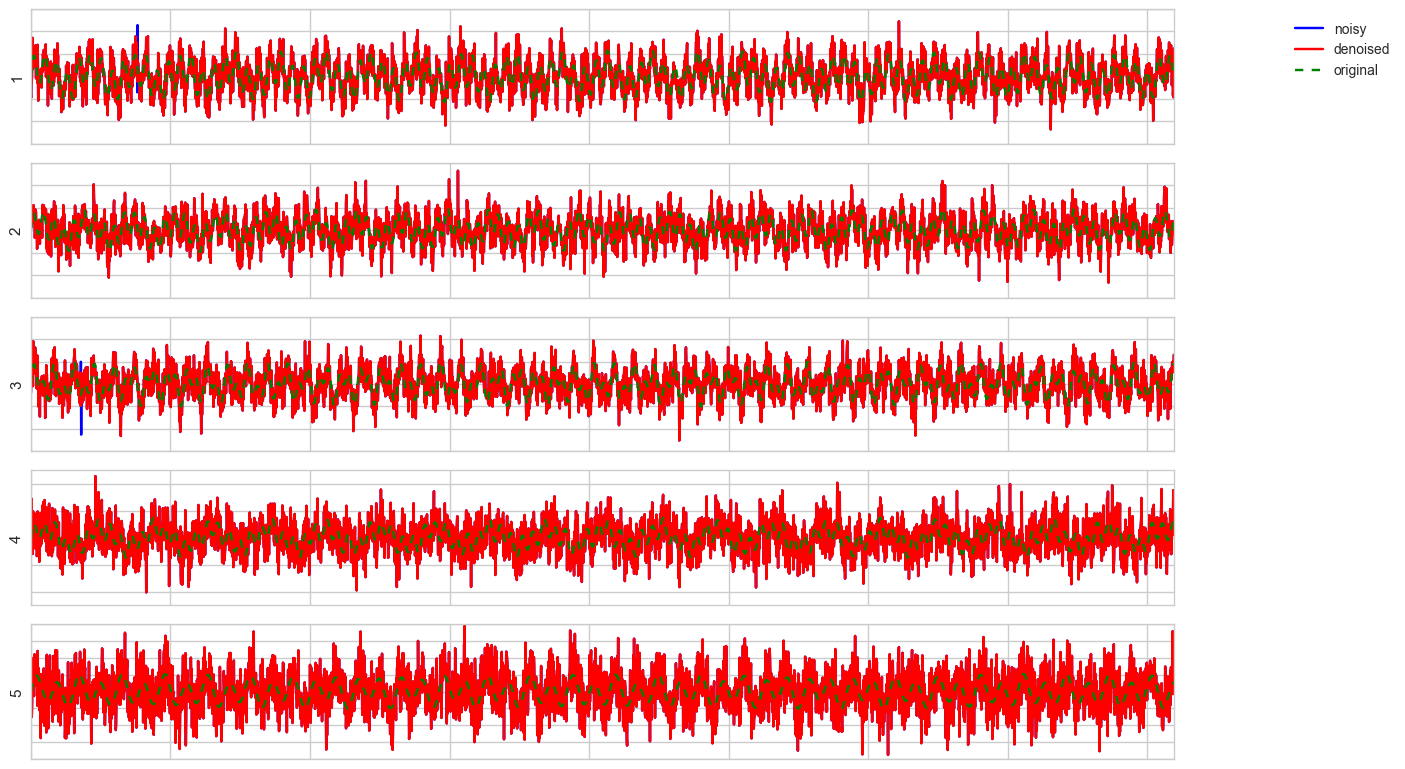

In [7]:
from panda.methods.denoise import wave_rejection
import pywt
# don't reconstruct in function
p_global['wave_rej']['rec'] = False
p_global['wave_rej']['thresh'] = 4
Y, S = bad_data(5, p_global)
before = pywt.wavedec(Y[0, :], 'db2', level = 10)
coef_pyramid_plot(before, title = 'Wavelet Coefficients: Before')
plt.show()
(S_hat, p_local) = wave_rejection(Y, p_local, p_global)
coef_pyramid_plot(S_hat[0], title = 'Wavelet Coefficients: After')
plt.show()
res = [before[i] - S_hat[0][i] for i in range(len(before))]
coef_pyramid_plot(res, title = 'Wavelet Coefficients: Before - After')
plt.show()
sigs = []
for coef in S_hat:
    sigs.append(pywt.waverec(coef, 'db2'))
sparklines(S, Y, np.vstack(sigs), '')
#plt.show()

##### Quantitative Assessment (bad)
We do not expect the denoised signal to be much closer to the latent signal here than the noisy signal is, since the assumptions of the method we have chosen are not applicable for the bad data.

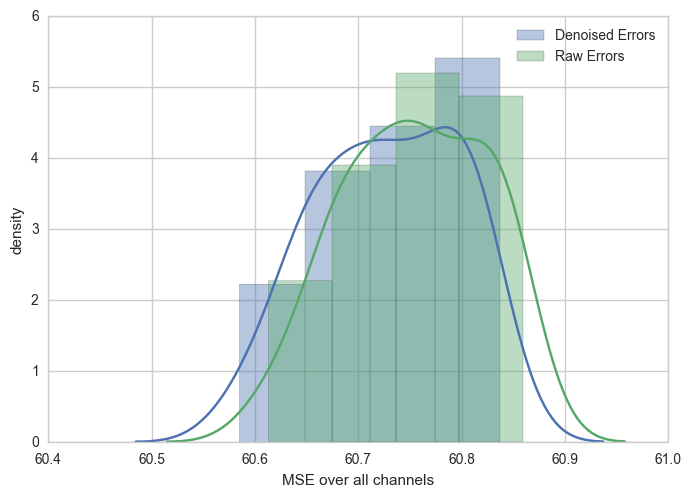

In [8]:
den_errs = []
raw_errs = []
p_global['wave_rej']['rec'] = True
for i in range(50):
    bigd = 111
    Y, S = bad_data(bigd, p_global)
    (S_hat, p_local) = wave_rejection(Y, {}, p_global)
    den_errs.append(np.linalg.norm(S_hat - S) / (bigd))
    raw_errs.append(np.linalg.norm(Y - S) / (bigd))
sns.distplot(den_errs, label='Denoised Errors')
sns.distplot(raw_errs, label='Raw Errors')
plt.xlabel('MSE over all channels')
plt.ylabel('density')
plt.legend()
plt.show()

### Application to Real Data
#### Running on real data

In [18]:
p_global['wave_rej']['thresh'] = 8
p_global['wave_rej']['rec'] = False
(W_wr, p_local) = wave_rejection(D, p_local, p_global)
p_global['wave_rej']['rec'] = True
(D_wr, p_local) = wave_rejection(D, p_local, p_global)

#### Results
##### Heatmaps

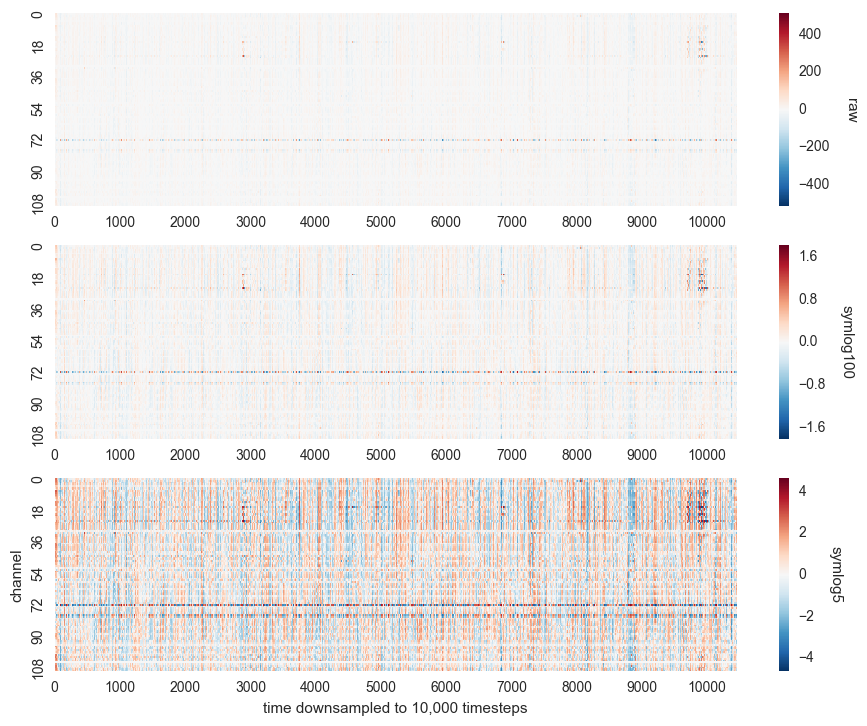

In [19]:
viz.heatmap(D_wr, {'eog_in': False}, p_global)

##### Pyramids

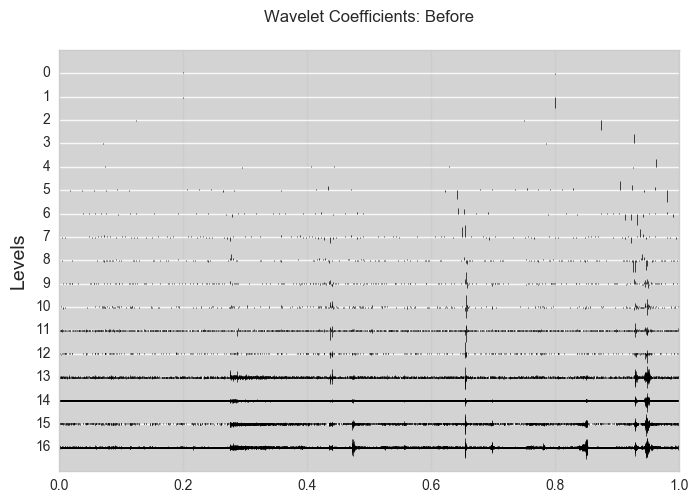

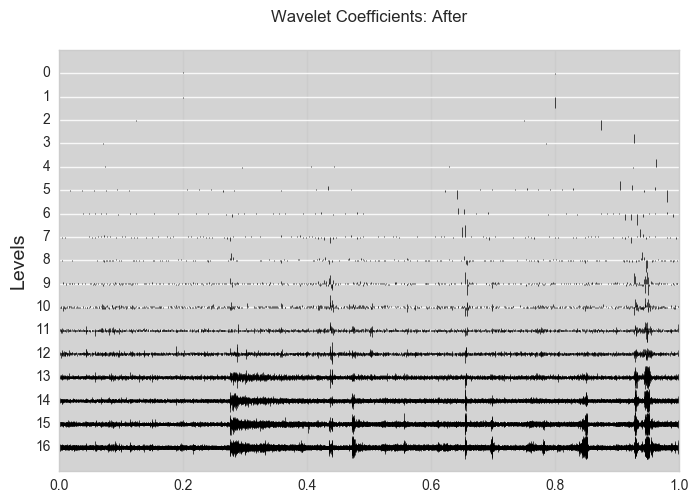

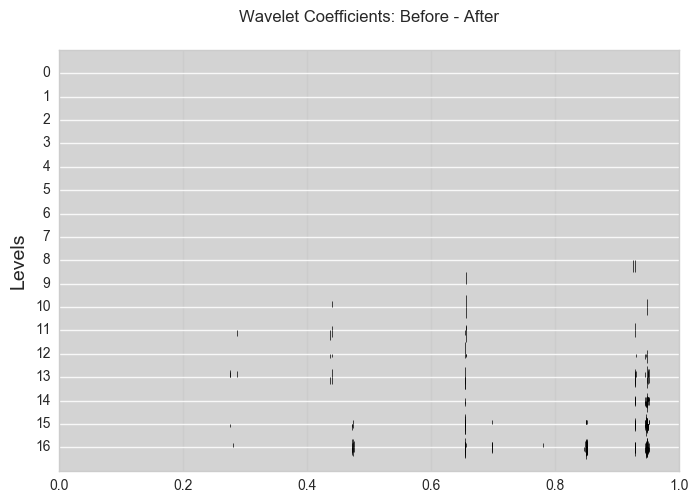

In [20]:
before = pywt.wavedec(D[16, :], 'db2', level = None)
coef_pyramid_plot(before, title = 'Wavelet Coefficients: Before')
plt.show()
coef_pyramid_plot(W_wr[16], title = 'Wavelet Coefficients: After')
plt.show()
res = [before[i] - W_wr[16][i] for i in range(len(before))]
coef_pyramid_plot(res, title = 'Wavelet Coefficients: Before - After')
plt.show()

##### Sparklines

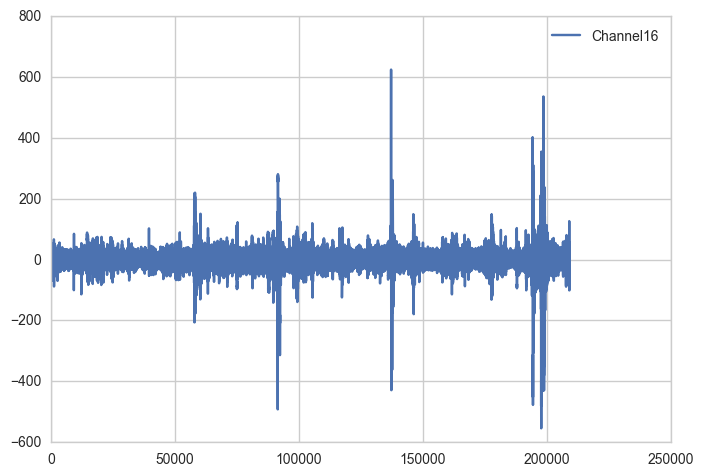

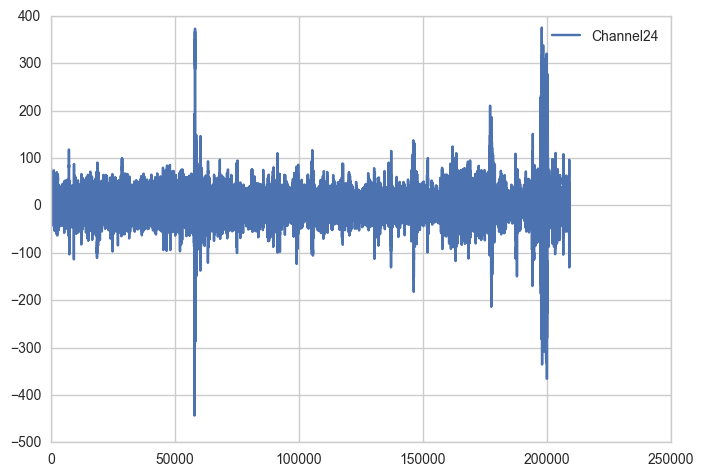

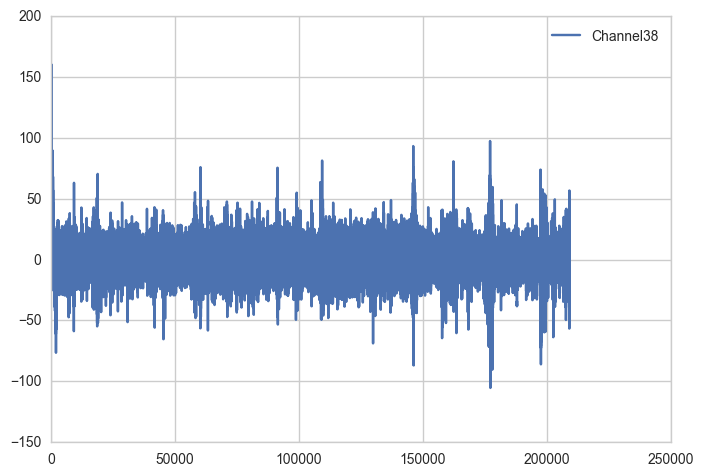

In [22]:
for i in sparkchans:
    plt.plot(D_wr[i, :], label = 'Channel' + str(i))
    plt.legend()
    plt.show()

##### Residual Heatmaps

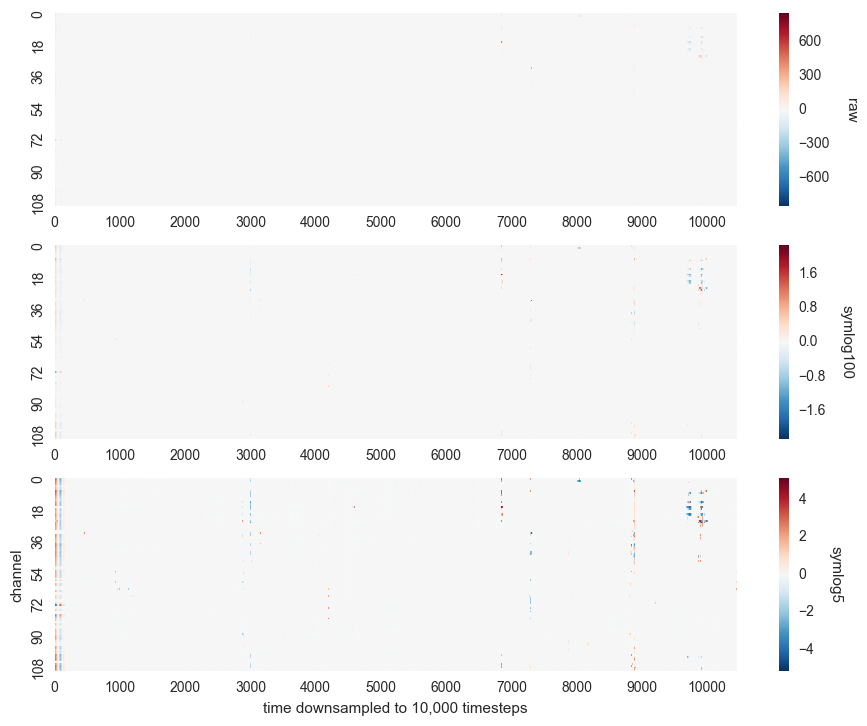

In [23]:
viz.heatmap((D_wr - D), {'eog_in': False}, p_global)

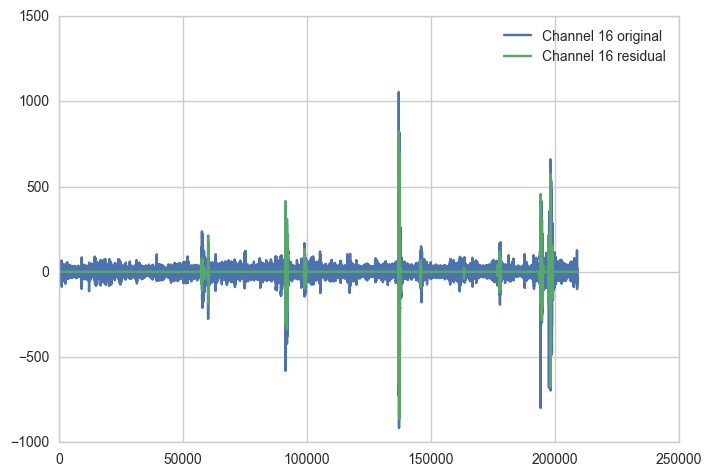

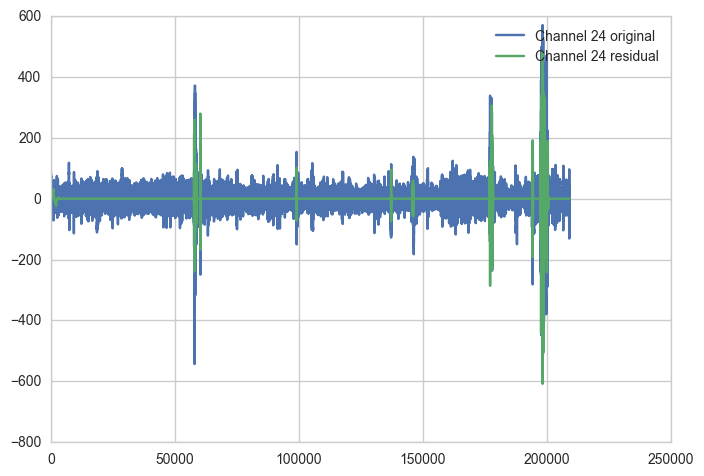

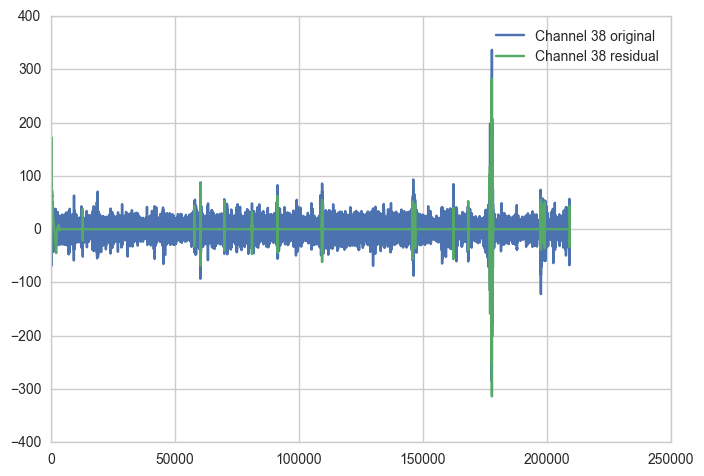

In [24]:
for i in sparkchans:
    plt.plot(D[i, :], label = 'Channel ' + str(i) + ' original')
    plt.plot(D_wr[i, :] - D[i, :], label = 'Channel ' + str(i) + ' residual')
    plt.legend()
    plt.show()

#### Results...
Here are the discriminibility results after running this function on an entire dataset (after the preceding functions in the pipeline)...
![image](../results/bids_raw/disc-heat-_wave_rejection.png)
And here are the distributions of the intra and inter subject distances.
![image](../results/bids_raw/dists-wave_rejection.png)